In [1]:
#Importing required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import cartopy.crs as ccrs
import glob as glob
import netCDF4 as nc
from netCDF4 import Dataset
from scipy.stats import skew,stats
import bottleneck
import gcsfs
#import cfgrib
import matplotlib.ticker as mticker

import warnings

In [2]:
#Loading CMIP6 data stored on google cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()       #print the first few rows of the file

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [3]:
df_pr = df.query("activity_id=='HighResMIP' & (variable_id == 'psl' ) & (experiment_id == 'highresSST-present'|experiment_id == 'highresSST-future') & source_id=='MRI-AGCM3-2-S' & table_id == 'Amon'")
df_pr

print(df_pr.zstore.values[0])

gs://cmip6/CMIP6/HighResMIP/MRI/MRI-AGCM3-2-S/highresSST-present/r1i1p1f1/Amon/psl/gn/v20190711/


In [4]:
# get the path to a specific zarr store (the first one from the dataframe above)
psl_store_present = df_pr.zstore.values[0] # present-day simulation
print(psl_store_present)                    #print to make sure we are reading the correct dataset
# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(psl_store_present)
# open it using xarray and zarr
dpsl_present = xr.open_zarr(mapper, consolidated=True)

gs://cmip6/CMIP6/HighResMIP/MRI/MRI-AGCM3-2-S/highresSST-present/r1i1p1f1/Amon/psl/gn/v20190711/


In [5]:
# Display the dataset for present-day:
dpsl_present

<xarray.Dataset>
Dimensions:    (lat: 960, bnds: 2, lon: 1920, time: 780)
Coordinates:
  * lat        (lat) float64 -89.86 -89.67 -89.48 -89.3 ... 89.48 89.67 89.86
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(960, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 0.1875 0.375 0.5625 ... 359.2 359.4 359.6 359.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(1920, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(780, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    psl        (time, lat, lon) float32 dask.array<chunksize=(33, 960, 1920), meta=np.ndarray>
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           HighResMIP
    branch_method:         no parent
    cmor_version:          3.3.2
    creation_date:         2019-06-12T08:56:23Z
    data_specs_version:    01.00.23
    ...                    ...
    tracking_id:           hdl:21.14100/394fccc5-c8b8-4fb6-84d8-4d48654d96a4\...
    variable_id:           psl
    variant_label:         r1i1p1f1
    status:                2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:   hdl:21.14100/394fccc5-c8b8-4fb6-84d8-4d48654d96a4\...
    version_id:            v20190711

In [6]:
#Loading precipitation data and converting units to mm/day
psl_present = dpsl_present.psl * 86400           #converting units to mm/day
psl_present.attrs = dpsl_present.psl.attrs       # copy the variable attributes (metadata) from the original pr variable
psl_present.attrs ['units'] = 'mm/day'         # change the units in the metadata to mm/day
psl_present

<xarray.DataArray 'psl' (time: 780, lat: 960, lon: 1920)>
dask.array<mul, shape=(780, 960, 1920), dtype=float64, chunksize=(33, 960, 1920), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.86 -89.67 -89.48 -89.3 ... 89.3 89.48 89.67 89.86
  * lon      (lon) float64 0.0 0.1875 0.375 0.5625 ... 359.2 359.4 359.6 359.8
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Sea Level Pressure
    long_name:      Sea Level Pressure
    original_name:  SLP
    standard_name:  air_pressure_at_sea_level
    units:          mm/day

In [7]:
#Determining 30 year mean of present-day precipitation
psl_present_amn = psl_present.sel(time=slice('1981-01-16T12:00:00' , '2010-12-16T12:00:00')).mean(dim='time')  # calculate climatological annual mean (present-day)
psl_present_amn.attrs=psl_present.attrs                                                                        # copy the variable attributes (metadata) from the original pr variable
psl_present_amn
# You can save this as a netcdf file with: 
psl_present_amn.to_netcdf("psl_present_amn_MRI-AGCM3-2-S.nc") # you can give the path to where you want the dataset to be saved, and its name. If no path is provided, then the file is saved in the present working directory

In [8]:
psl_present_amn

<xarray.DataArray 'psl' (lat: 960, lon: 1920)>
dask.array<mean_agg-aggregate, shape=(960, 1920), dtype=float64, chunksize=(960, 1920), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.86 -89.67 -89.48 -89.3 ... 89.3 89.48 89.67 89.86
  * lon      (lon) float64 0.0 0.1875 0.375 0.5625 ... 359.2 359.4 359.6 359.8
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Sea Level Pressure
    long_name:      Sea Level Pressure
    original_name:  SLP
    standard_name:  air_pressure_at_sea_level
    units:          mm/day

In [ ]:
lon=psl_present_amn.lon
lat=psl_present_amn.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax.contourf(lon, lat, psl_present_amn, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, psl_present_amn, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation (present-day)', loc='left', fontsize=26)
plt.title('MRI-AGCM3-2-S, 1981-2010 climo', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
# plt.savefig('prcp_anm_MRI-AGCM3-2-S_present.pdf')  
plt.show()

In [13]:
observed_precip='merra_tp.nc'     # provide the path to the the dataset and its name
ds_precip = xr.open_dataset(observed_precip,decode_times=False)      # read in the dataset
ds_precip 

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 361, time: 444)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) float64 0.0 4.464e+04 8.64e+04 ... 1.937e+07 1.942e+07
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes: (12/33)
    CDI:                               Climate Data Interface version 1.6.9 (...
    history:                           Thu May 16 16:50:04 2019: cdo -b 32 -f...
    Conventions:                       CF-1
    History:                           Thu Dec 31 15:03:19 2015: ncrename -v ...
    Filename:                          MERRA2_100.tavgM_2d_flx_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/0JRLVL8YV2Y4
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000
    NCO:                               "4.5.3"
    CDO:                               Climate Data Operators version 1.6.9 (...

In [14]:
timerange_precip = pd.date_range('1980-01', freq='MS', periods=len(ds_precip.time))    #here, we create a range of time coordinates, from the start date (Jan 1980) 
ds_precip.coords['time']=timerange_precip #replace time coordinates
ds_precip

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 361, time: 444)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2016-12-01
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes: (12/33)
    CDI:                               Climate Data Interface version 1.6.9 (...
    history:                           Thu May 16 16:50:04 2019: cdo -b 32 -f...
    Conventions:                       CF-1
    History:                           Thu Dec 31 15:03:19 2015: ncrename -v ...
    Filename:                          MERRA2_100.tavgM_2d_flx_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/0JRLVL8YV2Y4
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000
    NCO:                               "4.5.3"
    CDO:                               Climate Data Operators version 1.6.9 (...

In [15]:
# compute annual mean climatology from observations and change units to mm/day
pr_obs_amn=ds_precip.tp.sel(time=slice('1981-01-01','2010-12-01')).mean(dim='time')*86400
pr_obs_amn.attrs = ds_precip.tp.attrs       # copy the variable attributes (metadata) from the original pr variable
pr_obs_amn.attrs ['units'] = 'mm/day'         # change the units in the metadata to mm/day
pr_obs_amn

<xarray.DataArray 'tp' (lat: 361, lon: 576)>
array([[0.16270627, 0.16270627, 0.16270627, ..., 0.16270627, 0.16270627,
        0.16270627],
       [0.17217633, 0.17237769, 0.17257744, ..., 0.17156309, 0.17176875,
        0.17197322],
       [0.17540755, 0.17589172, 0.1763824 , ..., 0.1739925 , 0.17445808,
        0.17492968],
       ...,
       [0.76420617, 0.7638036 , 0.76340276, ..., 0.76542573, 0.76501766,
        0.76461148],
       [0.76899139, 0.7687852 , 0.76857618, ..., 0.76961681, 0.76940905,
        0.76919987],
       [0.76890252, 0.76890252, 0.76890252, ..., 0.76890252, 0.76890252,
        0.76890252]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Attributes:
    long_name:       total_precipitation
    units:           mm/day
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    origname:        PRECTOT
    fullnamepath:    /PRECTOT

Let's plot the observed precipitation, using the same colorbar as in the model, in order to easily see differences. 

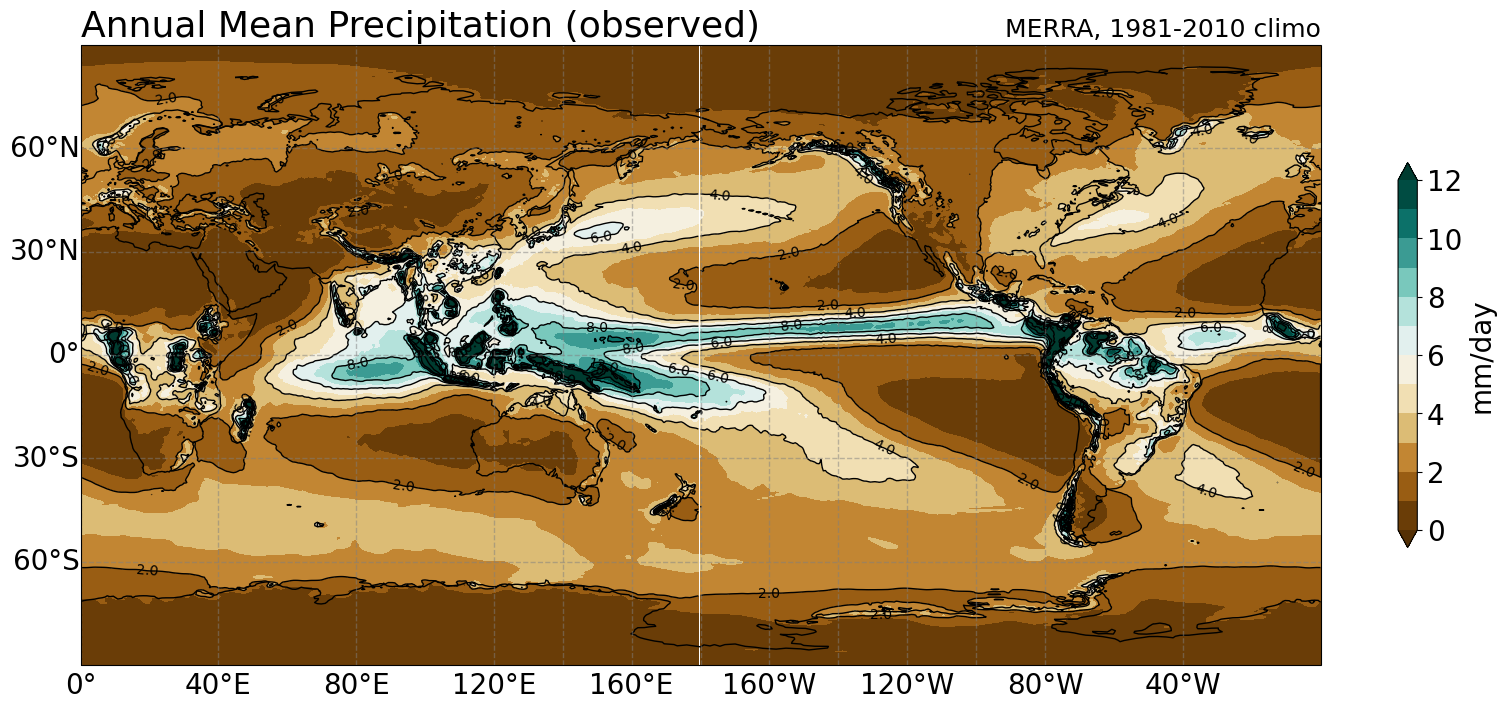

In [16]:
lon=pr_obs_amn.lon
lat=pr_obs_amn.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax.contourf(lon, lat, pr_obs_amn, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, pr_obs_amn, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation (observed)', loc='left', fontsize=26)
plt.title('MERRA, 1981-2010 climo', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
plt.savefig('prcp_anm_MERRA.pdf')  
plt.show()

Let's combine the plots in one graphic:

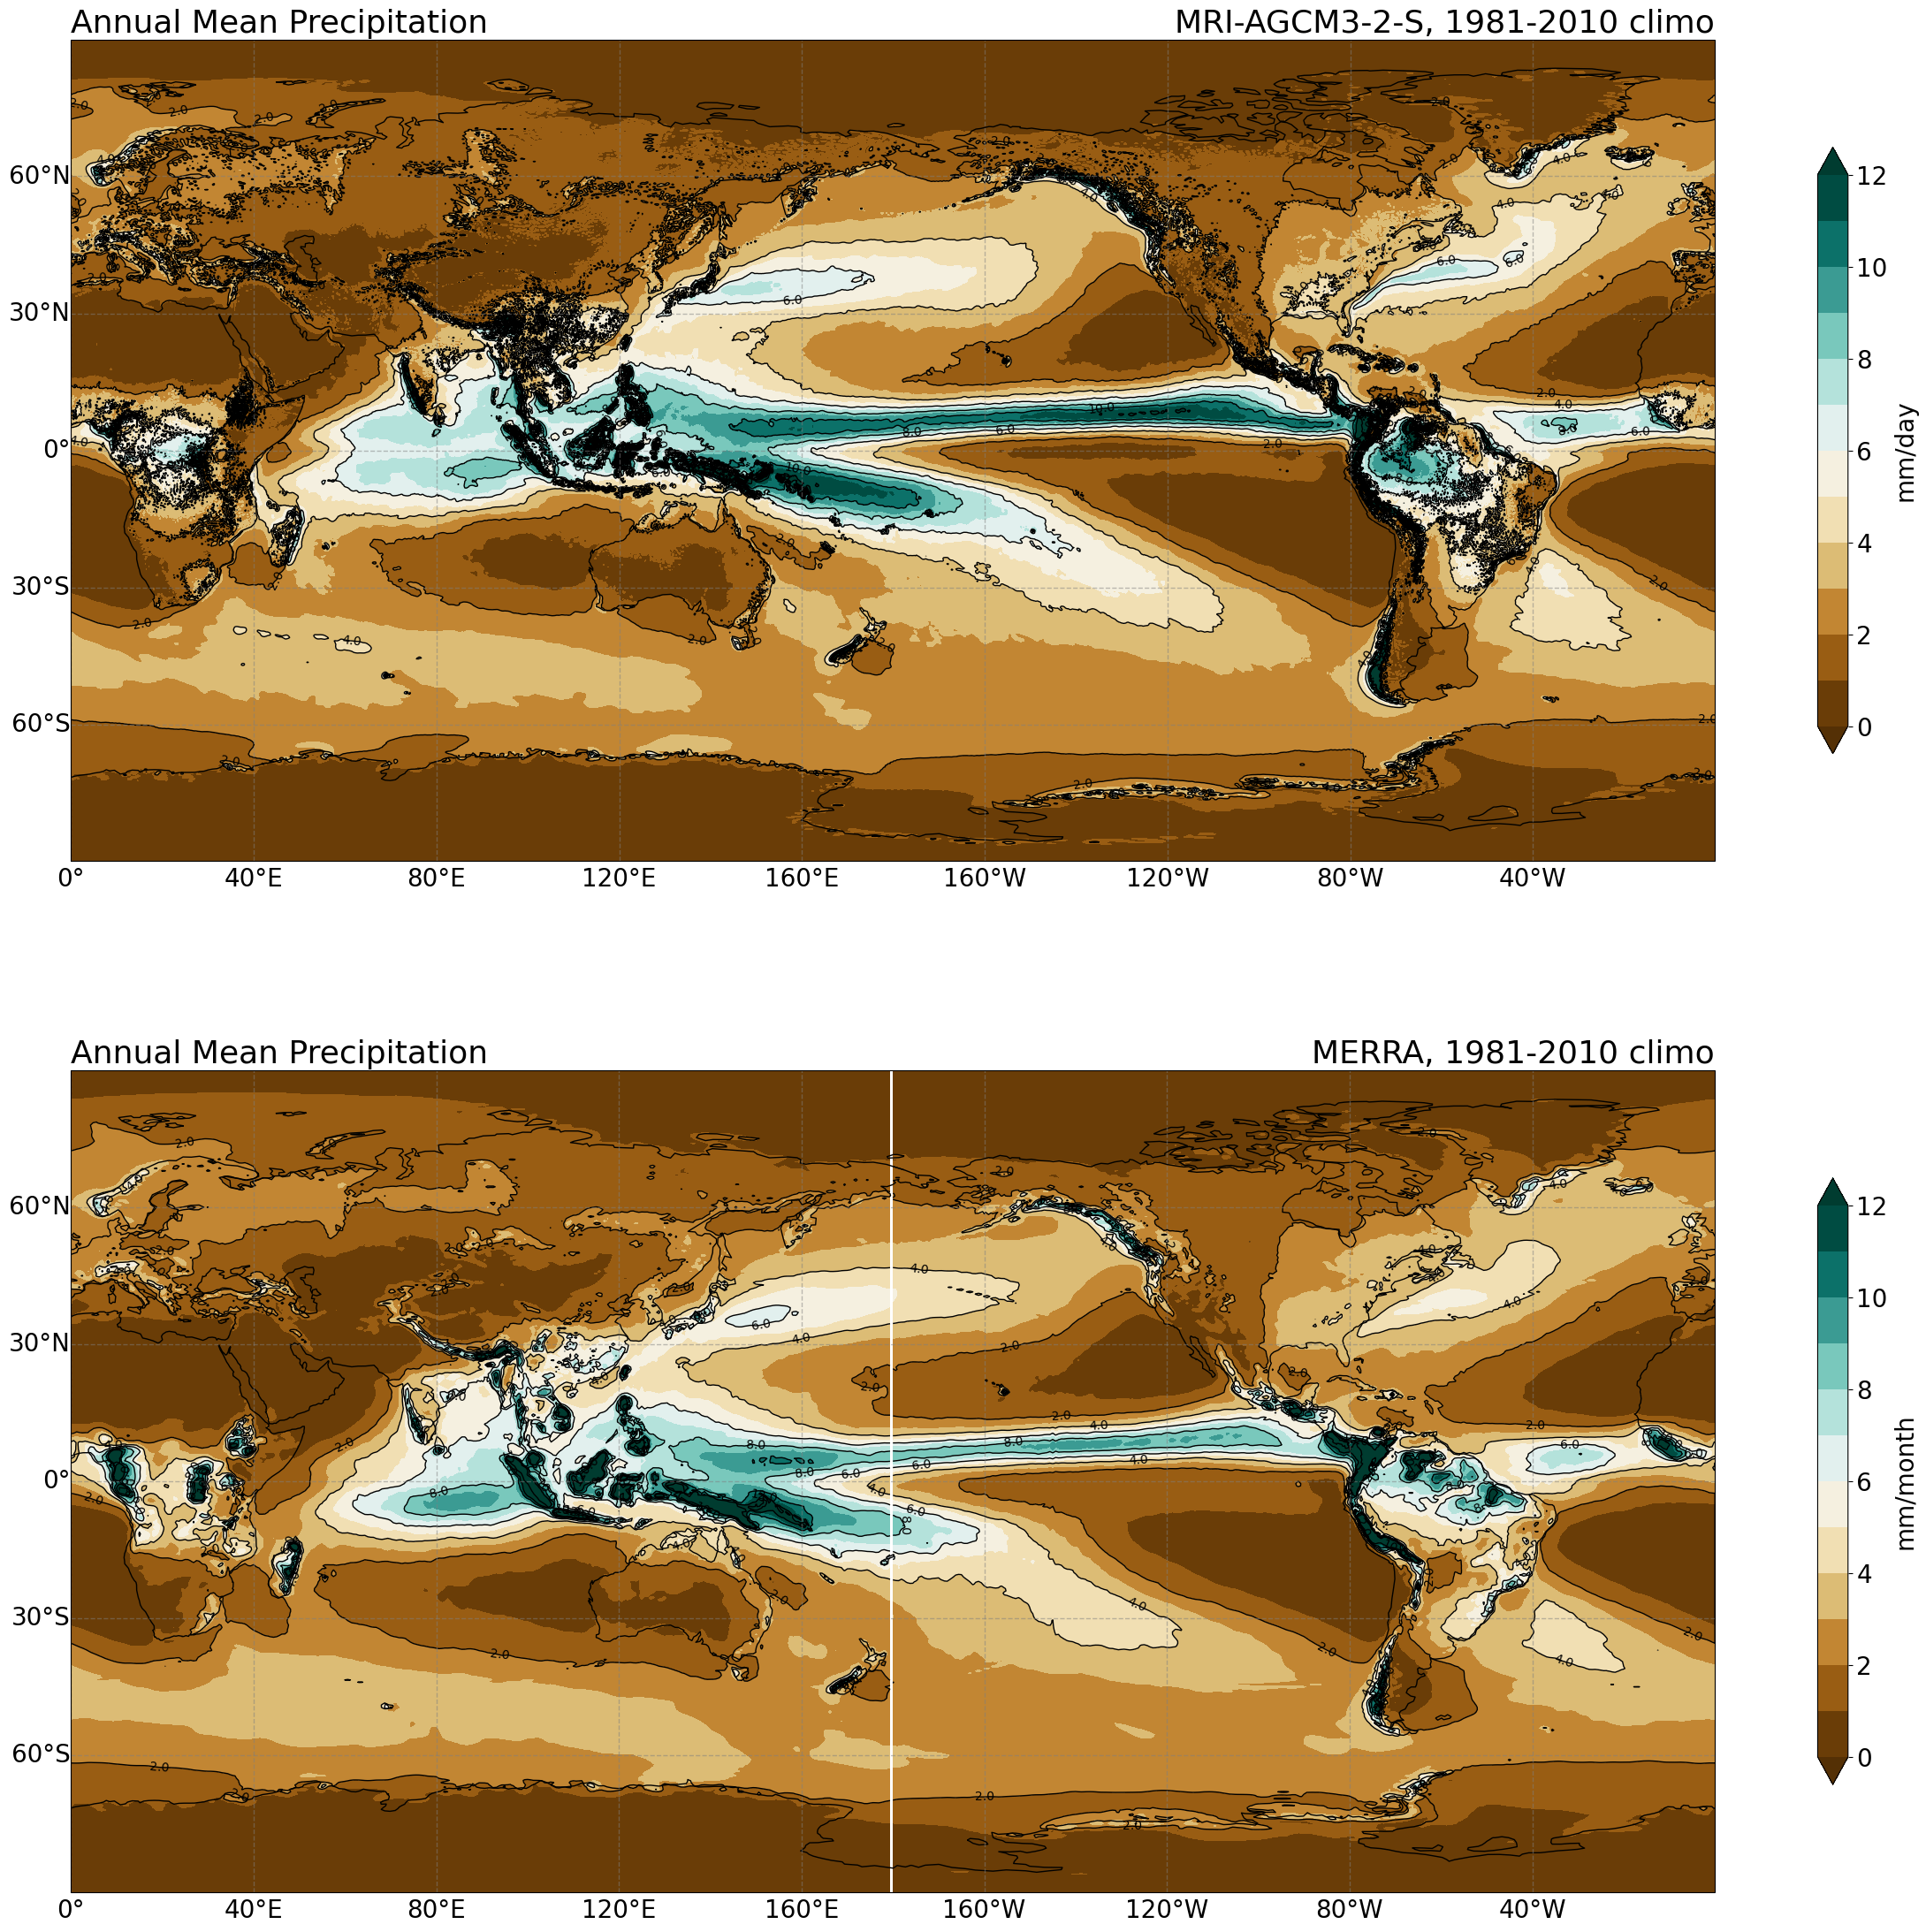

In [17]:
import matplotlib.gridspec as gridspec
#### Start figure
fig = plt.figure(figsize=(30, 30))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, width_ratios=[1],height_ratios=[1,1], wspace=0.02, hspace=0.02)

lon=pr_present_amn.lon
lat=pr_present_amn.lat
### First plot [0,0] : Model precipitation
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax1.contourf(lon, lat, pr_present_amn, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax1.contour(lon, lat, pr_present_amn, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation', loc='left', fontsize=26)
plt.title('MRI-AGCM3-2-S, 1981-2010 climo', loc='right', fontsize=26)
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 160, -160, -120, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}

### Second plot [0,1]: reanalysis (MERRA)
lon=pr_obs_amn.lon
lat=pr_obs_amn.lat
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax2.contourf(lon, lat, pr_obs_amn, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax2.contour(lon, lat, pr_obs_amn, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/month', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation', loc='left', fontsize=26)
plt.title('MERRA, 1981-2010 climo', loc='right', fontsize=26)
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 160, -160, -120, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}

plt.savefig('precip_model_vs_obs.pdf')  
plt.show()

> **Part I, Question 4:** Discuss this model's performance in simulating annual mean precipitation.
(i.e. how well does it simulates annual mean precipitation compared to the observed values? Where does it overestimate, and where does it underestimate precipitation? Any other features that you observe in your comparison?)


(You could also create a difference map here to assess model skill, but to do that, you would need to re-grid the datasets to a common grid)



---


### Calculate the change in precipitation between two climates

---



Now that we have a sense of how skillful the model is in simulating annual mean precipitation, we will look at the changes it projects under a future climate scenario. 

We first plot the annual mean precipitation from the future simulation, which we calculated above. 

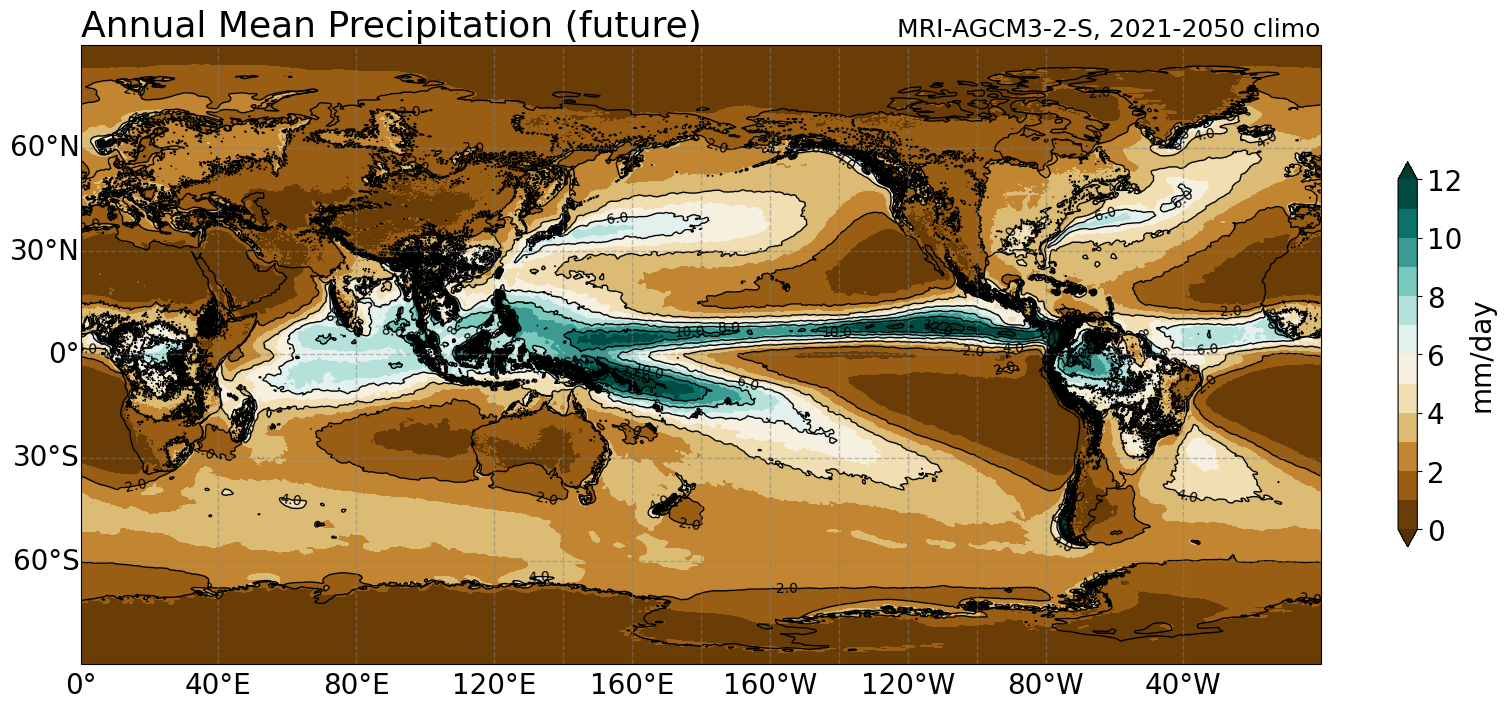

In [18]:
lon=pr_future_amn.lon
lat=pr_future_amn.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax.contourf(lon, lat, pr_future_amn, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, pr_future_amn, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=10, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation (future)', loc='left', fontsize=26)
plt.title('MRI-AGCM3-2-S, 2021-2050 climo', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
plt.savefig('prcp_anm_MRI-AGCM3-2-S_future.pdf')  
plt.show()

Now, let's calculate the difference (i.e. change) in annual mean precipitation between the two climates: 

In [19]:
pr_diff = pr_future_amn - pr_present_amn
pr_diff.attrs = pr_future.attrs         # copy the variable attributes (metadata) from the original pr variable
pr_diff

<xarray.DataArray 'pr' (lat: 960, lon: 1920)>
dask.array<sub, shape=(960, 1920), dtype=float64, chunksize=(960, 1920), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.86 -89.67 -89.48 -89.3 ... 89.3 89.48 89.67 89.86
  * lon      (lon) float64 0.0 0.1875 0.375 0.5625 ... 359.2 359.4 359.6 359.8
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    long_name:      Precipitation
    original_name:  PRECIPI
    standard_name:  precipitation_flux
    units:          mm/day

Now, we can plot the difference in precipitation between the two climates: 

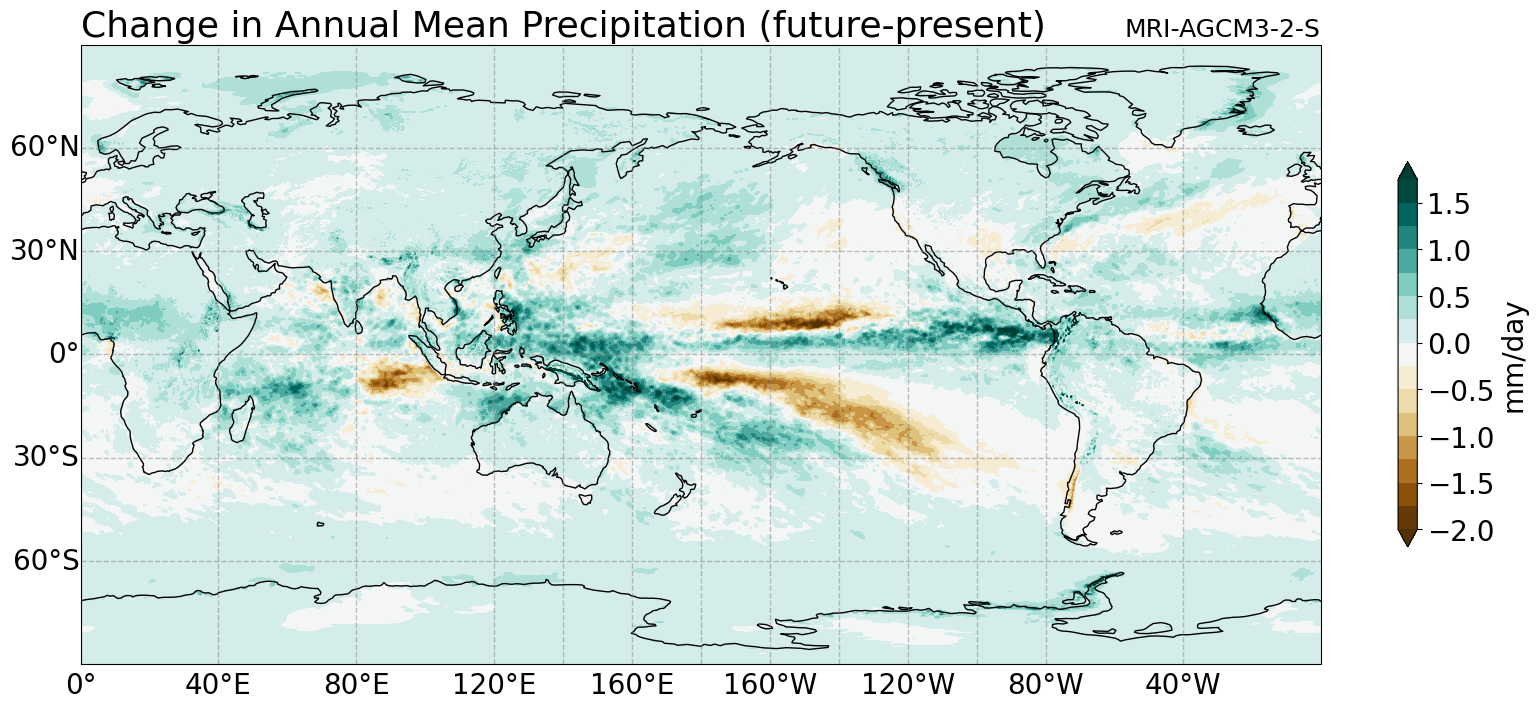

In [20]:
lon=pr_diff.lon
lat=pr_diff.lat
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-2, 2, 0.25)
# filled contours
cf = ax.contourf(lon, lat, pr_diff, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Change in Annual Mean Precipitation (future-present)', loc='left', fontsize=26)
plt.title('MRI-AGCM3-2-S', loc='right', fontsize=18)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([0,40,80,120, 140, 160, 180, -160, -140, -120, -100, -80,-40])
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}
plt.savefig('change_prcp_anm_MRI-AGCM3-2-S.pdf')  
plt.show()

> **Question 5:** What are the main changes in precipitation that you observe between future and present climate, as simulated by this model?

---------------
## Focus on Hawaii
--------------

Here, we will sub-select and study precipitation in the two climates in the HI region. 

In [21]:
# Select from the present-day, future, and difference datasets a box around HI
pr_present_hi = pr_present_amn.sel(lat=slice(18, 23),lon=slice(199, 208))
pr_future_hi = pr_future_amn.sel(lat=slice(18, 23),lon=slice(199, 208))
pr_diff_hi = pr_diff.sel(lat=slice(18, 23),lon=slice(199, 208))

Now, we will plot the present-day and future projected annual mean precipitation, as well as their difference. 

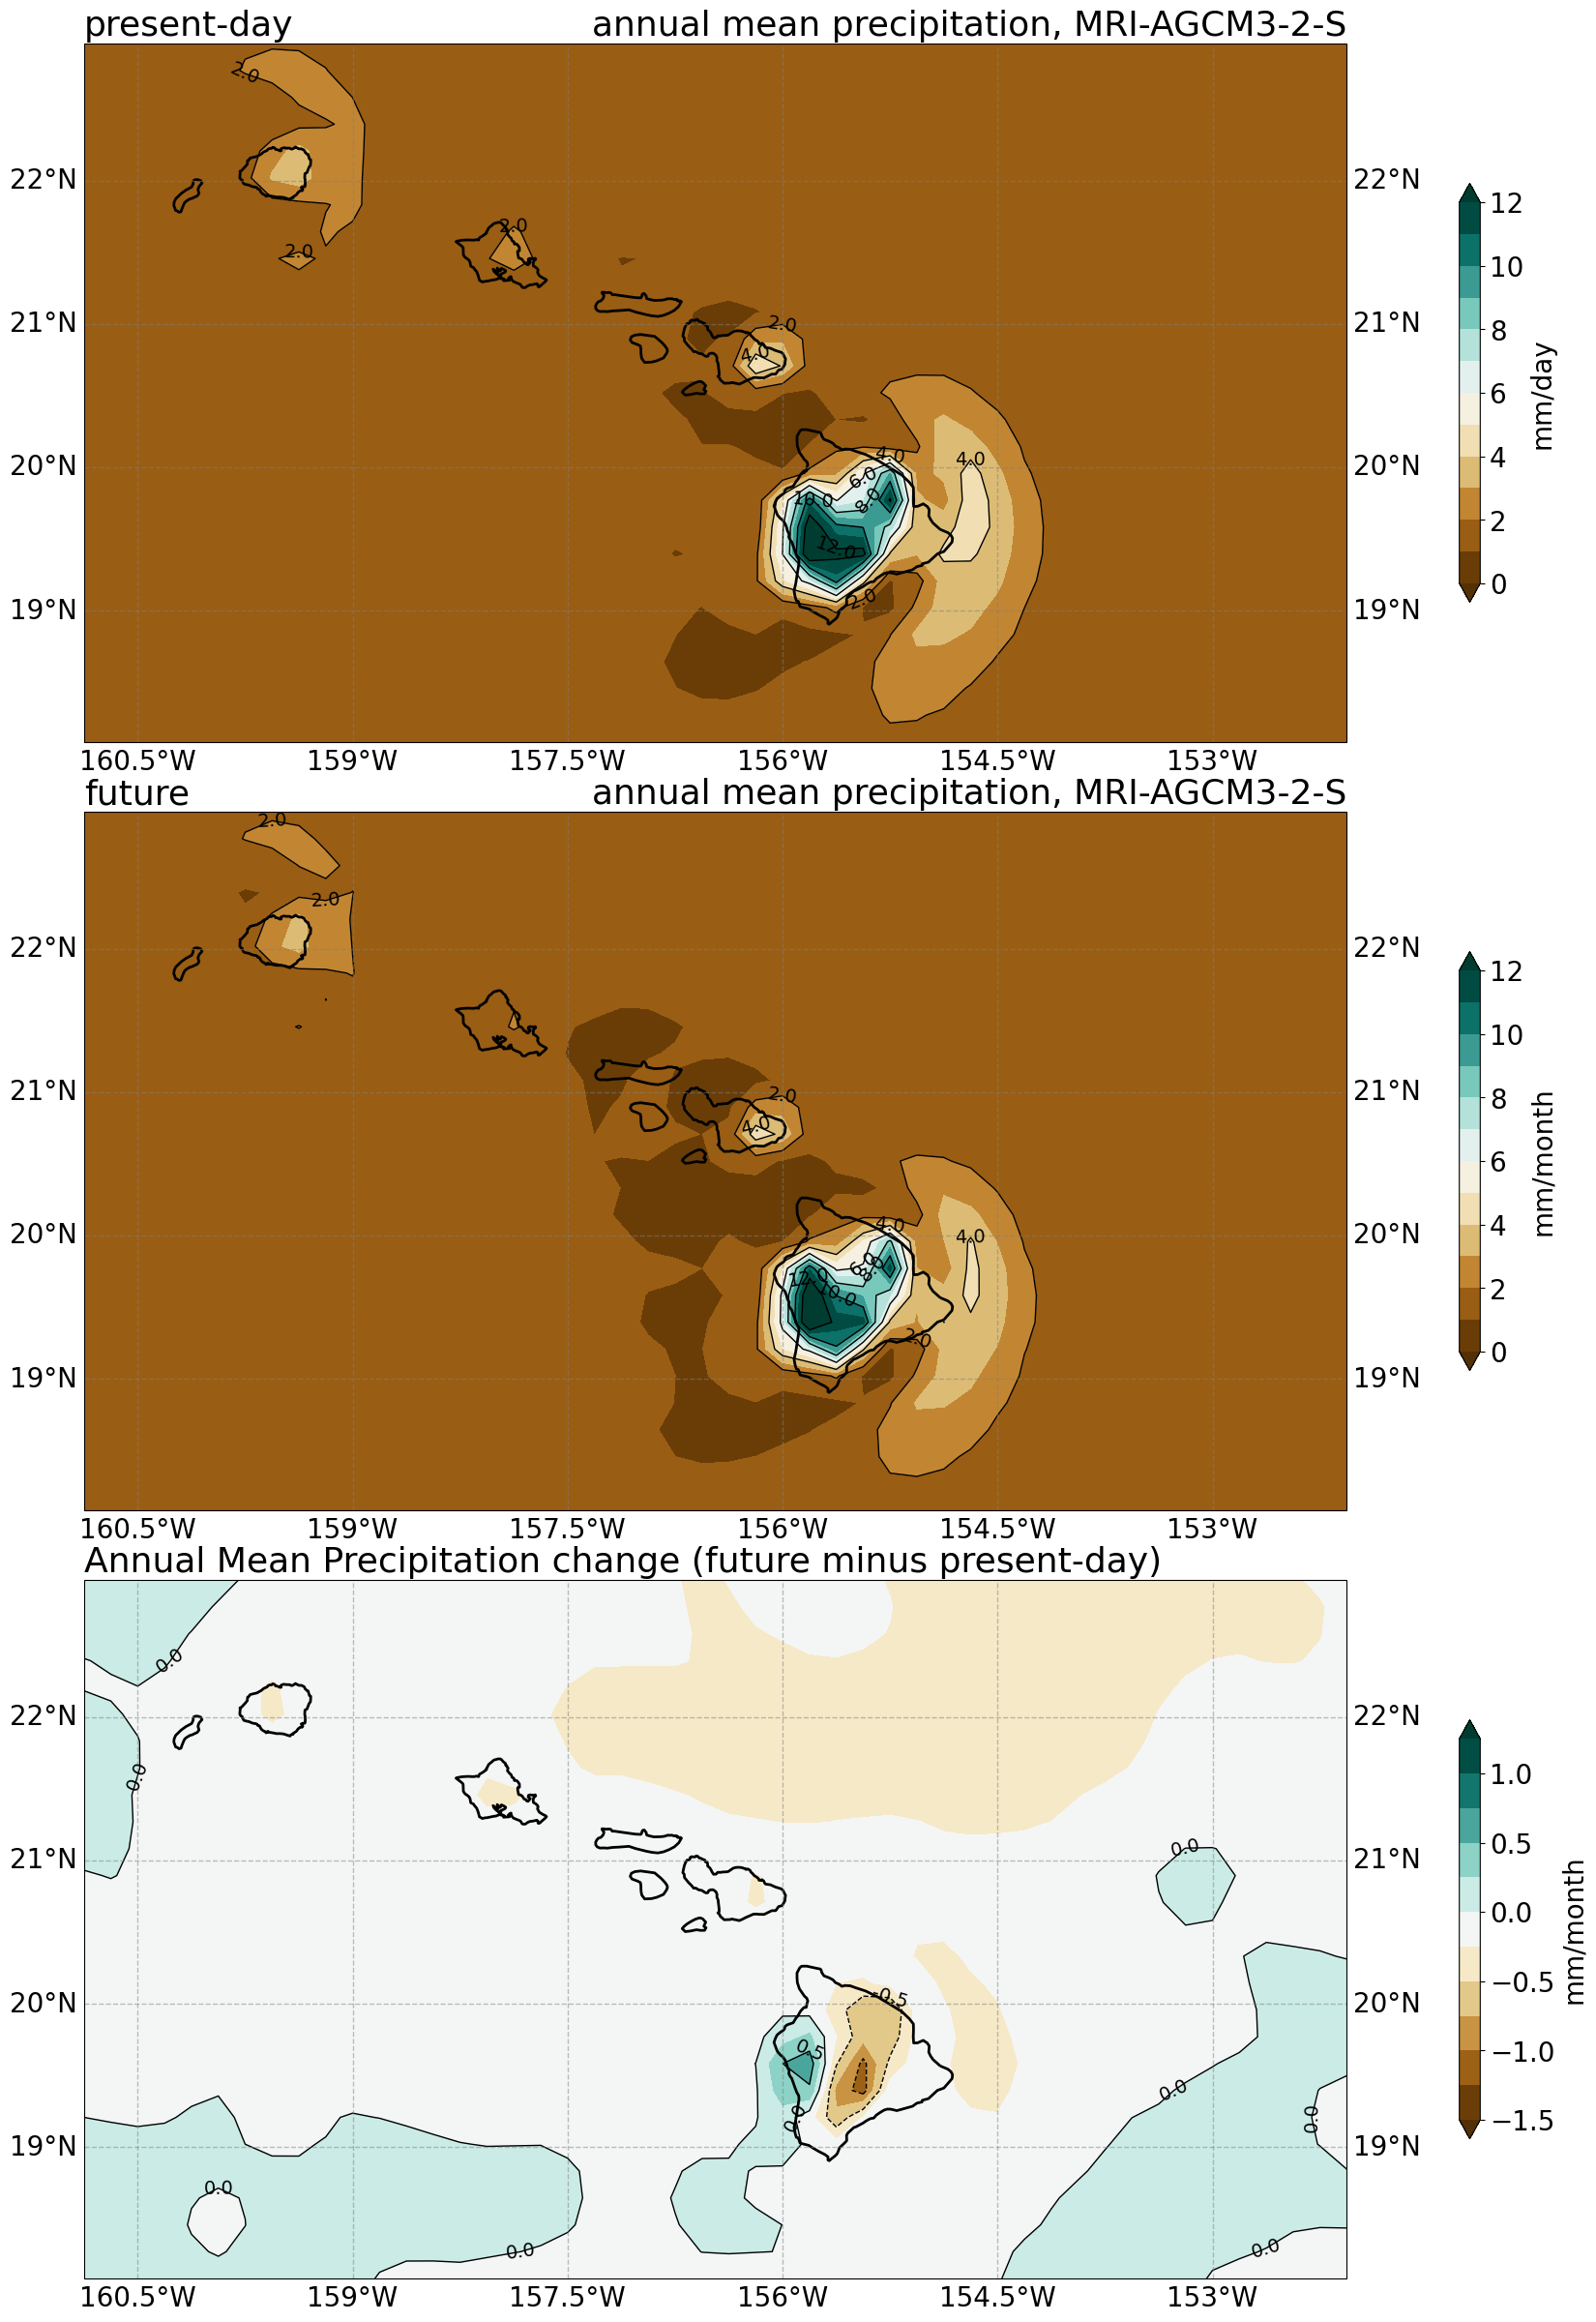

In [23]:
import matplotlib.gridspec as gridspec
#### Start figure
fig = plt.figure(figsize=(30, 30))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=3, ncols=1, width_ratios=[1],height_ratios=[1,1,1], wspace=0.02, hspace=0.1)

lon=pr_present_hi.lon
lat=pr_present_hi.lat
### First plot [0,0] : Model precipitation
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax1.contourf(lon, lat, pr_present_hi, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax1.contour(lon, lat, pr_present_hi, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=14, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/day', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('present-day', loc='left', fontsize=26)
plt.title('annual mean precipitation, MRI-AGCM3-2-S', loc='right', fontsize=26)
ax1.coastlines(linewidth=2)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}

### Second plot [1,0]: future
lon=pr_future_hi.lon
lat=pr_future_hi.lat
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(0, 13, 1)
# filled contours
cf = ax2.contourf(lon, lat, pr_future_hi, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax2.contour(lon, lat, pr_future_hi, colors='k', linewidths=1,levels=np.arange(0, 13, 2),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=14, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/month', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('future', loc='left', fontsize=26)
plt.title('annual mean precipitation, MRI-AGCM3-2-S', loc='right', fontsize=26)
ax2.coastlines(linewidth=2)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}


### Third plot [2,0]: future
lon=pr_diff_hi.lon
lat=pr_diff_hi.lat
ax2 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180.0))
levels = np.arange(-1.5, 1.5, 0.25)
# filled contours
cf = ax2.contourf(lon, lat, pr_diff_hi, cmap='BrBG',levels=levels,extend='both',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax2.contour(lon, lat, pr_diff_hi, colors='k', linewidths=1,levels=np.arange(-2, 2, 0.5),
                transform=ccrs.PlateCarree())
# add contour labels
lb = plt.clabel(cs, fontsize=14, inline=False, fmt='%0.1f');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6)
cb.ax.set_title('', fontsize=14)
cb.set_label('mm/month', fontsize=20)
cb.ax.tick_params(labelsize=20)
# Set some titles
plt.title('Annual Mean Precipitation change (future minus present-day)', loc='left', fontsize=26)
plt.title('', loc='right', fontsize=26)
ax2.coastlines(linewidth=2)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = True
gl.xlines = True
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20,'color': 'black'}


plt.savefig('combined_precip_change_MRI-AGCM3-2-S_HAWAII.pdf')  
plt.show()

> **Part I, Question 6:** What are the  main projected changes in precipitation in HI in this model?  

--------
# Part II: Analyze a different climate model
----------------

In Part II of your assignment, you are asked to repeat the above analysis for a different model, and answer the following questions: 




> **Part II, Question 1:** Discuss this new model's performance in simulating annual mean precipitation.

> **Part II, Question 2:** Upload the map of global annual mean precipitation changes in this new model.  

> **Part II, Question 3:** What are the main changes in precipitation that you observe between future and present climate, as simulated by this new model? How is it different compared to model MRI-AGCM3-2-S? 

> **Part II, Question 4:** Upload the map of annual mean precipitation changes **in HI** in this new model.  

> **Part II, Question 5:** What are the main changes in precipitation that you observe between future and present climate **in HI**, as simulated by this new model? How is it different compared to model MRI-AGCM3-2-S? 



The model you are asked to analyze in **Part II*, depends on the last digit of your UH ID:

* **0, or 6:** GFDL-CM4C192
* **1, or 7:** HadGEM3-GC31-MM, member_id: r1i1p1f1
* **2, or 8:** HadGEM3-GC31-LM, member_id: r1i1p1f1
* **3, or 9:** HadGEM3-GC31-HM, member_id: r1i1p1f1
* **4:** CMCC-CM2-HR4
* **5:** MRI-AGCM3-2-H


>Copy the analysis code that was used for model MRI-AGCM3-2-S (or make a copy of the whole notebook), and make the necessary changes to analyze your new model:

First, in the query, you need to select your new model instead of MRI-AGCM3-2-S. Then, check the list of available simulations. There will be present-day simulations (highresSST-present) and future simulations (highresSST-future). Depending on the order in which they appear in your list, you may need to change the indices for the selection of runs 

This refers to the commands: 

```
pr_store_present = df_pr.zstore.values[0] 
pr_store_future = df_pr.zstore.values[1] 
```


 

The code block that performs the selection includes a printout of the selected datasets, which allows you to confirm that you have indeed read the correct files. 

These commands are: 
```
print(pr_store_present)
print(pr_store_future)
```

After you confirm that you have correctly read the datasets that correspond to your new model, the rest of the commands should not require any significant changes. Note that you should change the model name in the titles of your plots, and you may also need to change the range of the colorbar to correctly display your maps because each model will have different results. 


# END